<a href="https://colab.research.google.com/github/TorbjornLarsson/SMI/blob/main/preparatory_notebooks/F8_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: F8 -- Model learning as numerical optimization

This notebook is complementary to lecture F8 about model learning as numerical optimization. The purpose of the notebook is to highlight key concepts. It is also an opportunity to refresh your knowledge and gain intuition. The focus will be on:
1. **Visualising the cost landscape** for a regression problem
2. **Visualising gradient descent**
3. Explore how the **learning rate** affects the **convergence of gradient descent**

Please read the instructions and play around with the notebook where it is described.


---

We start by importing necessary libraries. Please run the cell below.

In [1]:
from ipywidgets import interact
from fastai.basics import *
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
plt.rc('figure', dpi=90)

---

## 1. Visualising the cost landscape for a regression problem

Let's say that we have some training data and we want to fit a model on the following form to our data:

$$
f_{\mathbf{\theta}}(x) = \theta_{1}x + \theta_2x^2
$$

We have previously seen how we can find a model by using the mean squared error (MSE) and then finding $\theta_2$ and $\theta_1$ by using the normal equations. Instead of using the mean squared error, there are alternative cost functions that can be used, such as the mean absolute error (MAE). which is defined as follows:

$$
J(\mathbf{\theta}) = \frac{1}{m} \sum_{i=1}^{m} |{(y_i - f_{\mathbf{\theta}}(x_i))}|
$$

Unfortunately, there is no closed form solution to the optimization problem that arises when we use this cost function. Because of this we must use an alternative way to find a model. In this notebook we will explore how we can use the numerical optimization algorithm *gradient descent* to find $\theta_2$ and $\theta_1$.

We start by generating our training data and having a look at it. We also visualise our cost function as a three dimensional plot. Here, $\theta_2$ is on the x-axis, $\theta_1$ is on the y-axis and the cost for each combination of $\theta_1$ and $\theta_2$ is plotted on the z-axis.

Task:
- Run the cell below. Don't worry too much about understanding the code.
- Have a look at the training data and the visualisation of the cost function.
- By simply looking at the visualisation of the cost function, roughly what values of $\theta_1$ and $\theta_2$ would be appropariate if we want to minimize the MAE?

/tmp/ipython-input-537644418.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = y_true * (1+noise_term[0]) + noise_term[1]
/tmp/ipython-input-537644418.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  def MAE_cost_(y_hat, y_data): return (np.abs(y_hat-y_data)).mean()


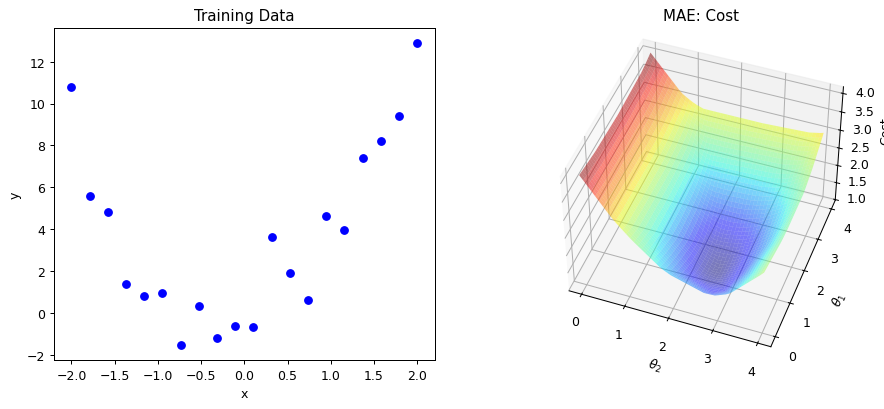

In [2]:
# define model and cost
def model(theta1, theta2, x): return  theta1*x + theta2*x**2
def dynamic_model(theta1, theta2): return partial(model, theta1, theta2)
def MAE_cost(y_hat, y_data): return (torch.abs(y_hat-y_data)).mean()
def MAE_cost_(y_hat, y_data): return (np.abs(y_hat-y_data)).mean()
def cost(theta1, theta2): return MAE_cost_(dynamic_model(theta1, theta2)(x), y)
def MAE_cost_dynamic(params): return  MAE_cost(dynamic_model(*params)(x), y)
def plot_model(fun, title, color='orange'):
    x = torch.linspace(-2.1,2.1,100)[:,None]
    plt.plot(x, fun(x), color)
    plt.title(title)

# generate training data
np.random.seed(42)
theta1_, theta2_ = 2, 3
x = torch.linspace(-2, 2, steps=20)[:,None]
y_true, y_true_s = model(theta1_, theta2_, x), model(theta1_, theta2_, x).shape
noise_term = np.array([np.random.normal(loc=0, scale=0.15, size=y_true_s), np.random.normal(loc=0, scale=1.5, size=y_true_s)])
y = y_true * (1+noise_term[0]) + noise_term[1]

# plot training data and cost function
grid_x = np.linspace(0, 4, 50)
grid_y = np.linspace(0, 4, 50)
X, Y = np.meshgrid(grid_x, grid_y)
Z = np.zeros((50, 50))
for x1 in range(len(X)):
    for y1 in range(len(Y)):
        Z[x1][y1] = cost(X[x1][y1], Y[x1][y1])
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('x'),ax.set_ylabel('y')
ax.set_title("Training Data")
plt.scatter(x,y, color='blue');
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("MAE: Cost")
ax.set_xlabel(r"$\theta_2$")
ax.set_ylabel(r"$\theta_1$")
ax.set_zlabel("Cost")
ax.zaxis.label.set_rotation(90)
im=ax.plot_surface(Y, X, Z, rstride=1, cstride=1,cmap='jet', edgecolor = 'none', alpha = 0.5)
ax.view_init(azim=290, elev=45)

Theta1 ~1.5, theta2 ~2.5

When doing gradient descent, our goal is to find values of the parameters $\theta_1$ and $\theta_2$ which will minimize the cost. We will later explore how we can do this in an automated manner, but for now we can start by seeing if we can manually find good parameter values.

Task:
- Run the cell below to visualise the data, current model and cost landscape.
- Move the sliders for $\theta_1$ and $\theta_2$ and examine how different parameter values give us different models and costs.
- Choose a set of values for $\theta_1$ and $\theta_2$ that you think minimizes the MAE. What is the cost for the parameter values you choose?

The sliders "azim" and "elev" can be used to visualise the plot of the cost function from different angles. The initial values are azim = 290 and elev = 45. You don't have to move these sliders if you don't want to.

In [3]:
@interact(theta1=(-4.0, 4.0, 0.01), theta2=(-4.0, 4.0, 0.01), azim=(0, 360, 1), elev=(-360, 360, 1))
def interactive_plot(theta1,theta2, azim=290, elev=45):
    fig = plt.figure(figsize=plt.figaspect(0.4))
    ax = fig.add_subplot(1, 2, 1)
    plt.scatter(x,y, color='blue');
    dynamic_model2 = dynamic_model(theta1, theta2)
    MAE2 =  MAE_cost(dynamic_model2(x), y)
    plot_model(dynamic_model2, f"Current cost: {MAE2.item():.4f}")

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_title("MAE: Cost")
    ax.set_xlabel(r"$\theta_2$")
    ax.set_ylabel(r"$\theta_1$")
    ax.set_zlabel("Cost")
    ax.zaxis.label.set_rotation(90)
    ax.plot_surface(Y, X, Z, rstride=1, cstride=1,cmap='jet', edgecolor = 'none', alpha = 0.5)
    ax.scatter(theta2,theta1,cost(theta1,theta2), c='r')
    ax.view_init(azim=azim, elev=elev)
    plt.show();

interactive(children=(FloatSlider(value=0.0, description='theta1', max=4.0, min=-4.0, step=0.01), FloatSlider(…

---

## 2. Visualising gradient descent

You may have noticed that the cost for a particular set of parameter values decreases if we follow the slope of the cost function when we adjust the parameter values. The gradient of the cost function, $\nabla_\mathbf{\theta}J(\mathbf{\theta}) = (\frac{\partial J(\mathbf{\theta})}{\partial \theta_1}, \frac{\partial J(\mathbf{\theta})}{\partial \theta_2})$, describes in which direction the cost $J(\mathbf{\theta})$ increases. Similarly, $-\nabla_\mathbf{\theta}J(\mathbf{\theta})$ describes in which direction the cost decreases. This is the intuition behind gradient descent.

Task:
- Run the cell below to visualise the data, current model and cost landscape.
- Move the sliders for $\theta_1$ and $\theta_2$ and examine how different parameter values give us different models, costs and local gradients.
- Choose a set of values for $\theta_1$ and $\theta_2$ that you think minimizes the MAE. What is the cost for the parameter values you choose? Try to take the values of the gradient into account when you increase or decrease the parameter values. Can you find better values of $\theta_1$ and $\theta_2$ than in the previous tasks, by using the information about the gradients?

In [4]:
def interactive_plot_gradient(theta1,theta2, azim=290, elev=45, grads=None):
    fig = plt.figure(figsize=plt.figaspect(0.4))
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_title("Cost Function")
    ax.set_xlabel(r"$\theta_2$")
    ax.set_ylabel(r"$\theta_1$")
    ax.set_zlabel("Cost")
    ax.zaxis.label.set_rotation(90)
    ax.plot_surface(Y, X, Z, rstride=1, cstride=1,cmap='jet', edgecolor = 'none', alpha = 0.5)
    current_cost = cost(theta1,theta2)
    ax.scatter(theta2,theta1,current_cost, c='r')
    param_tensor = torch.tensor([theta1,theta2])
    if grads==None:
        param_tensor.requires_grad_()
        cost_param = MAE_cost_dynamic(param_tensor)
        cost_param.backward()
        param_tensor.grad
    else:
        param_tensor.grad = grads
    ax.set_title(f"Gradients: Theta 1: {param_tensor.grad[0]:.4f}, Theta 2: {param_tensor.grad[1]:.4f}")
    start = [theta2, theta1, current_cost]
    direction_theta1 = [0, param_tensor.grad[0]*-1, 0]
    direction_theta2 = [param_tensor.grad[1]*-1, 0, 0]
    ax.quiver(start[0], start[1], start[2], direction_theta1[0], direction_theta1[1], direction_theta1[2])
    ax.quiver(start[0], start[1], start[2], direction_theta2[0], direction_theta2[1], direction_theta2[2])
    ax.quiver(start[0], start[1], start[2], direction_theta2[0],direction_theta1[1], 0)
    ax.view_init(azim=azim, elev=elev)
    ax = fig.add_subplot(1, 2, 1)
    plt.scatter(x,y, color='blue');
    dynamic_model3 = dynamic_model(theta1,theta2)
    MAE3 = MAE_cost(dynamic_model3(x), y)
    plot_model(dynamic_model3, f"Current cost: {MAE3.item():.4f}")
    plt.show();

@interact(theta1=(-4.0, 4.0, 0.01), theta2=(-4.0, 4.0, 0.01), azim=(0, 360, 1), elev=(-360, 360, 1))
def interactive_plot_gradient_(theta1,theta2, azim=290, elev=45): interactive_plot_gradient(theta1,theta2, azim, elev)

interactive(children=(FloatSlider(value=0.0, description='theta1', max=4.0, min=-4.0, step=0.01), FloatSlider(…

As we have seen, we can reduce the cost by taking a small step in the direction of the negative gradient. Doing this systematically is exactly what gradient descent is about. One step of the gradient descent algorithm becomes

$$
\mathbf{\theta}^{(t+1)} = \mathbf{\theta}^{(t)} - \alpha \nabla_\mathbf{\theta}J(\mathbf{\theta}^{(t)}),
$$

where $t$ is an iteration index and $\alpha > 0$ is the learning rate (or step size).

Task:
- Run the cell below to initialize the gradient descent optimization solver. Don't worry about understanding the code.
- Run the *second* cell below multiple times. Each time you run it corresponds to one iteration of the gradient descent algorithm.
- How can you determine when the gradient descent algorithm has converged?
- Try changing the learning rate. What happens when you set it too high (eg. 1.0) or too low (e.g. 0.02)?

In [5]:
def take_gradient_descent_step(params, lr):
    total_cost = MAE_cost_dynamic(params)
    params.grad = None
    total_cost.backward()
    with torch.no_grad(): params -= params.grad*lr
    print(f'Iteration={i}: Cost={total_cost.item():.2f}, theta1={param_tensor[0]:.2f}, theta1_grad={param_tensor.grad[0]:.2f}, theta2={param_tensor[1]:.2f}, theta2_grad={param_tensor.grad[1]:.2f}')
    total_cost_ = total_cost.detach().numpy()
    return total_cost_

# Initialize the gradient descent solver
param_tensor = torch.tensor([0.,0.])
param_tensor.requires_grad_()
i = 0
cost_ = 0.0

Iteration=9: Cost=1.29, theta1=0.67, theta1_grad=-0.65, theta2=2.42, theta2_grad=-0.21


/tmp/ipython-input-537644418.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  def MAE_cost_(y_hat, y_data): return (np.abs(y_hat-y_data)).mean()


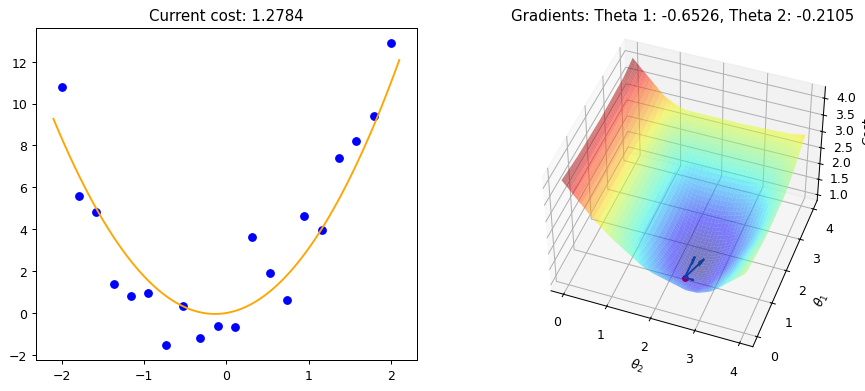

In [14]:
learning_rate = 0.02

i += 1
cost_ = take_gradient_descent_step(param_tensor, learning_rate)
interactive_plot_gradient(theta1=float(param_tensor[0]),theta2=float(param_tensor[1]),grads=param_tensor.grad)

---

# Take-home message


*   Gradient descent is a numerical optimization algorithm that can be used to minimize the cost function with respect to the model parameters. Numerical optimization algorithms can be used when the loss function leads to an optimization problem which lacks a closed form solution.
*   When using numerical optimization algorithms, we may have one or several hyperparameters to tune. In the case of gradient descent, there is a single hyperparameter; the learning rate.
*   If the learning rate is too high, the gradient descent algorithm may not converge. Instead, we may end up jumping around the minimum without reaching it.
*   If the learning rate is too low, the convergence rate can be very slow.
*   In the example used to visualize gradient descent in this notebook, our  cost function had a single global minimum. In many cases, especially in deep learning, the cost landscape can be complex. What could happen if we run gradient descent in a situation where the cost function has several local minima?

**Recommendation for further reading:** The material covered in this notebook is well-covered in Chapter 5.4 in the course book.

**Sources:** The content of this notebook is based on [this tutorial](https://www.kaggle.com/code/christianwittmann/visualizing-gradient-descent-in-3d) on visualizing gradient descent.
